#### __08. 차원 축소__

__8.1 차원의 저주__

큰 수의 법칙에 의해 각 분류기가 약한 학습기일지라도 충분히 많고 다양하다면 앙상블은 강한 학습기가 될 수 있다. <br>
차원이 높아질수록 두 점 간의 평균 거리는 늘어난다. 이는 고차원 데이터셋에서도 마찬가지인데, <br>
대부분의 훈련 데이터가 서로 멀리 떨어져 있으므로, 예측을 위해 많은 외삽(extrapolation)을 해야 하고, <br>
이 경우 과대적합이 위험이 커진다. <br>
<br>


__8.2 차원 축소를 위한 접근 방법__

대부분의 실전 문제는 훈련 샘플이 모든 차원에 걸쳐 균일하게 퍼져 있지 않다. <br>
일부 특성들이 서로 강하게 연관되어 결과적으로 훈련 샘플이 고차원 공간 안의 저차원 부분공간(subspace) 가까이 놓여있다. <br>
<br>

__8.3 주성분 분석(PCA: principal component analysis)__

In [1]:
import sklearn
import numpy as np
np.random.seed(42)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

In [3]:
# 사이킷런의 PCA 모델은 SVD 분해 방법을 사용하여 구현
from sklearn.decomposition import PCA

angle = np.pi / 5
stretch = 5
m = 200

np.random.seed(3)
X = np.random.randn(m, 2) / 10
X = X.dot(np.array([[stretch, 0],[0, 1]])) # stretch
X = X.dot([[np.cos(angle), np.sin(angle)], [-np.sin(angle), np.cos(angle)]]) # rotate

# 사이킷런의 PCA 모델은 자동으로 데이터를 중앙에 맞춰줌
# PCA는 평균이 0임을 가정하고 진행
pca = PCA(n_components=2)
X2D = pca.fit_transform(X)

In [7]:
# W^d의 전치가 담겨 있음
pca.components_.T[:, 0]

array([-0.79644131, -0.60471583])

In [9]:
# 설명된 분산의 비율은 각 주성분의 축을 따라 있는 데이터셋의 분산 비율을 나타낸다
# 이 데이터는 분산의 95%가 첫 번째 PC를 따라 놓여 있다
pca.explained_variance_ratio_

array([0.95369864, 0.04630136])

In [14]:
# 아래 코드는 차원 축소를 하지 않고 PCA를 계산한 뒤 훈련 세트의 분산을 95%로 유지하는데 필요한 최소한의 차원 수를 계산
pca = PCA()
pca.fit(X)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

# 그 다음 n_components=d로 설정하여 PCA를 다시 실행한다
# 하지만 아래처럼 보존하려는 분산의 비율을 0.0 ~ 1.0 사이로 설정하는 편이 낫다
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X)

In [15]:
# mnist 데이터셋으로 실험
from sklearn.datasets import fetch_openml

mnist = fetch_openml("mnist_784", version=1, as_frame=False)

In [16]:
type(mnist)

sklearn.utils._bunch.Bunch

In [17]:
mnist.target = mnist.target.astype(np.uint8)

X = mnist["data"]
y = mnist["target"]

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [19]:
pca = PCA()
pca.fit(X_train)

cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
d

154

In [20]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)
pca.n_components_

154

In [21]:
# 각 샘플은 원래의 784개의 특성에서 154개의 특성으로 차원이 축소되었다
pca = PCA(n_components=154)
X_reduced = pca.fit_transform(X_train)

# 재구성 오차는 다음과 같다
X_recovered = pca.inverse_transform(X_reduced)

np.mean(np.sum(np.square(X_recovered - X_train), axis=1))

171385.92786831802

Text(0.5, 1.0, 'Compressed')

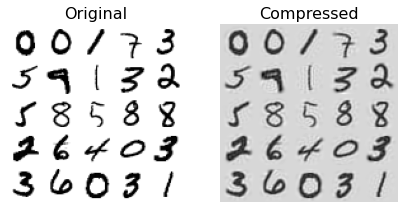

In [22]:
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

plt.figure(figsize=(7, 4))

# 왼편 원본 손글씨 데이터
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title("Original", fontsize=16)

# 오른편 재구성된 손글씨 데이터
plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title("Compressed", fontsize=16)

In [23]:
# 랜덤 PCA
X_reduced_pca = X_reduced
rnd_pca = PCA(n_components=154, svd_solver="randomized")
X_reduced = rnd_pca.fit_transform(X_train)

In [24]:
# 점진적 PCA
# PCA 구현의 문제는 SVD 알고리즘 실행을 위해 전체 훈련 세트를 메모리에 올려야 한다는 것이다
# 점진적(increaed)PCA는 훈련 세트를 미니배치로 나눈 뒤 IPCA 알고리즘에 한 번에 하나씩 주입한다

from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    inc_pca.partial_fit(X_batch)

X_reduced = inc_pca.transform(X_train)

__8.4 커널 PCA__

샘플을 매우 높은 고차원 공간(특성 공간: feature space)으로 암묵적으로 매핑하여 서포트 벡터 머신의 비선형 분류와 회귀를 <br>
가능하게 하는 수학적 기법인 커널 트릭에 대해서 공부했었다. 고차원 특성 공간에서의 선형 결정 경계는 원본 공간에서는 <br>
복잡한 비선형 결정 경계에 해당한다. <br>
<br>
PCA에 같은 기법을 적용하여 차원 축소를 위한 복잡한 비선형 투영을 수행할 수 있다.

In [28]:
from sklearn.datasets import make_swiss_roll
from sklearn.decomposition import KernelPCA

X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)
y = t > 6.9


rbf_pca = KernelPCA(n_components=2, kernel="rbf", gamma=0.04)
X_reduced = rbf_pca.fit_transform(X)

In [29]:
# 커널 선택과 하이퍼파라미터 튜닝
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf = Pipeline([
    ("kpca", KernelPCA(n_components=2)),
    ("log_reg", LogisticRegression())
])

param_grid = [{
    "kpca__gamma": np.linspace(0.03, 0.05, 10),
    "kpca__kernel": ["rbf", "sigmoid"]
}]

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, y)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kpca', KernelPCA(n_components=2)),
                                       ('log_reg', LogisticRegression())]),
             param_grid=[{'kpca__gamma': array([0.03      , 0.03222222, 0.03444444, 0.03666667, 0.03888889,
       0.04111111, 0.04333333, 0.04555556, 0.04777778, 0.05      ]),
                          'kpca__kernel': ['rbf', 'sigmoid']}])

In [31]:
grid_search.best_params_

{'kpca__gamma': 0.043333333333333335, 'kpca__kernel': 'rbf'}